# **Scalable Clustering for Customer Segmentation**

Scaling up clustering for massive datasets is a critical challenge in modern data science.
As data grows exponentially, traditional clustering algorithms like K-Means struggle with
computational efficiency and memory constraints.

In this notebook, we will:
- Explore scalability challenges.
- Showcase solutions: Mini-Batch K-Means, BIRCH.
- Compare performance and quality trade-offs.
- Provide insights for real-world applications.

## **1. Data Exploration**

We start by exploring the original dataset and generating a synthetic dataset to simulate scalability.

In [2]:
%pip install scikit-learn
import sklearn
print(sklearn.__version__)

Note: you may need to restart the kernel to use updated packages.
1.7.2


DATASET OVERVIEW

Dataset Shape: 200 rows × 5 columns
Current dataset size: 200 customers

First 5 rows:
   CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0           1   19                  15                      39         True
1           2   21                  15                      81         True
2           3   20                  16                       6        False
3           4   23                  16                      77        False
4           5   31                  17                      40        False

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
 4   Gender_Ma

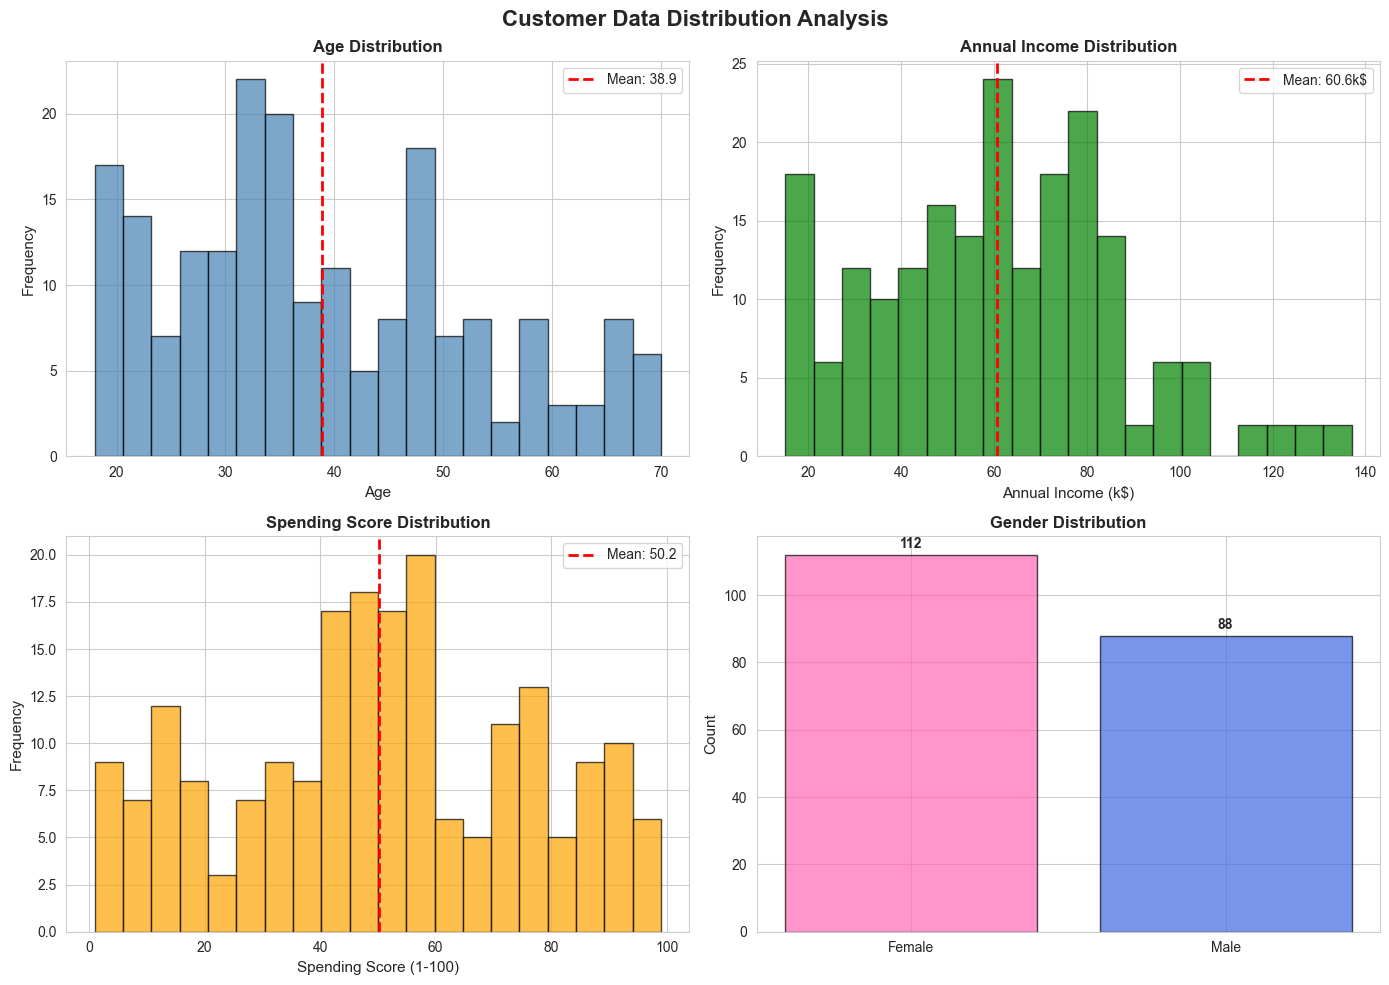

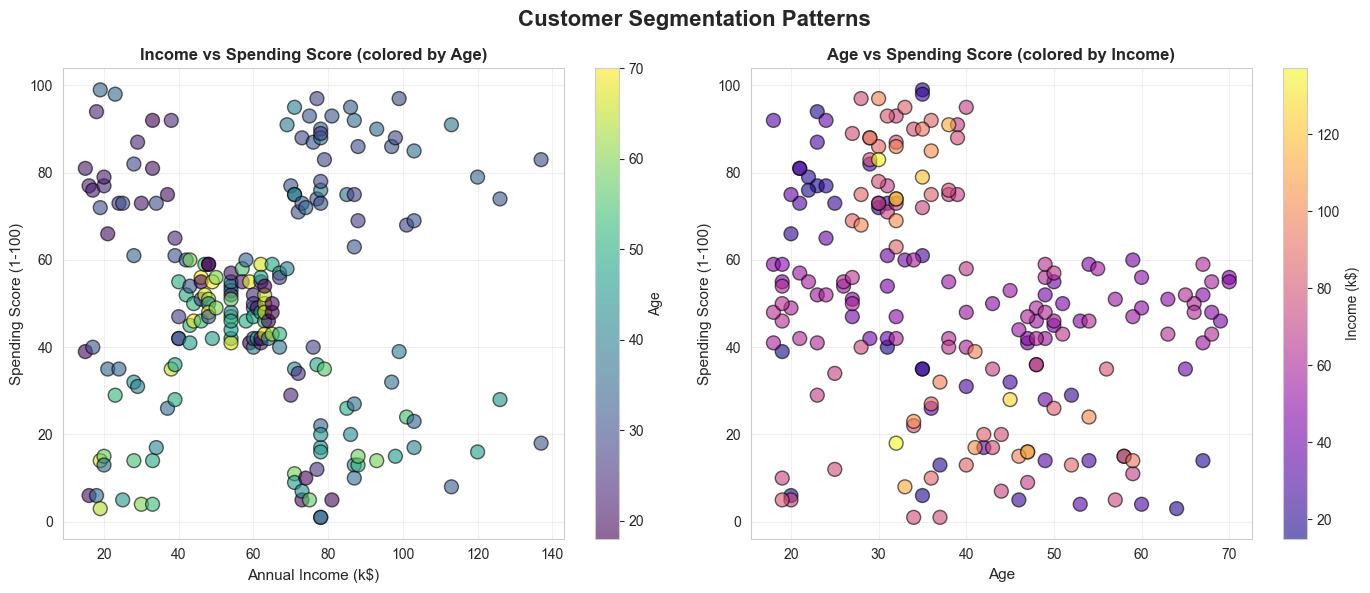

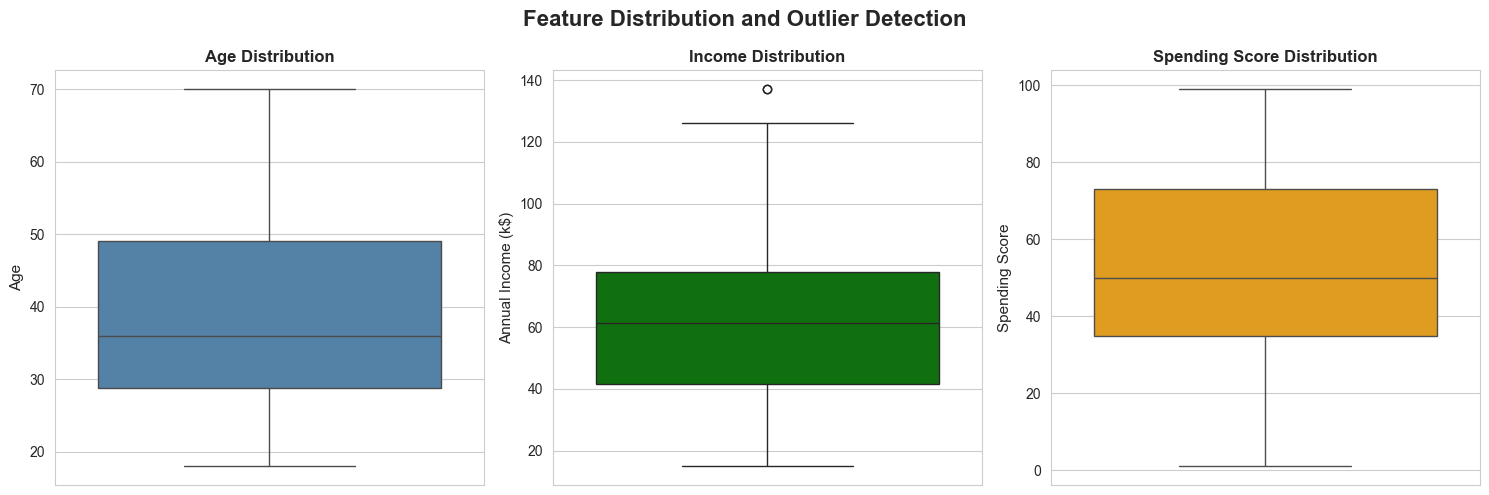


THE CHALLENGE: SCALING TO 200K CUSTOMERS

Current dataset: 200 customers
Target dataset: 200,000 customers (200k)
Scaling factor: 1000.0x increase

Challenges with 200k customers:
  • Computational time increases significantly
  • Memory requirements grow substantially
  • Standard K-Means may become impractical
  • Need for scalable algorithms (e.g., MiniBatch K-Means)

Let's test clustering performance at different scales...

Benchmarking K-Means clustering performance:
----------------------------------------------------------------------
   1k customers -> Clustering time:   0.0206s
  10k customers -> Clustering time:   0.0143s
  50k customers -> Clustering time:   0.0349s
 100k customers -> Clustering time:   0.0497s
 200k customers -> Clustering time:   0.1013s


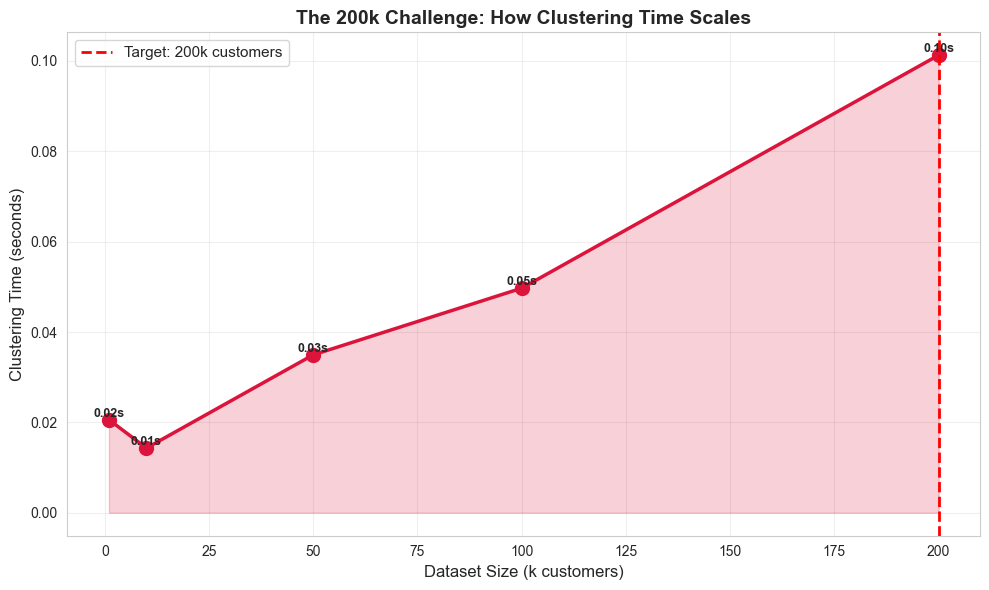


CONCLUSION:
At 200k customers, standard K-Means becomes computationally expensive.
This motivates the need for:
  1. Scalable algorithms (MiniBatch K-Means)
  2. Dimensionality reduction techniques
  3. Efficient implementation strategies

Next: Analyze time complexity and curse of dimensionality!


In [5]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans, MiniBatchKMeans
import time
import tracemalloc

# ============================================================================
# 1. LOAD DATASET
# ============================================================================

df = pd.read_csv('Mall_Customers.csv')

# One-Hot Encoding for Gender
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Select numeric columns
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']
X_original = df[columns].values.astype(float)

# Function to generate synthetic data
def generate_synthetic_data(X, n_samples):
    X = X.astype(float)
    replicated = np.tile(X, (n_samples // X.shape[0] + 1, 1))
    replicated = replicated[:n_samples]
    noise = np.random.normal(0, 0.05, replicated.shape)
    return replicated + noise

# ============================================================================
# 2. BASIC DATASET INFORMATION
# ============================================================================

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Current dataset size: {df.shape[0]} customers")
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

# ============================================================================
# 3. DESCRIPTIVE VISUALIZATIONS
# ============================================================================

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Graph 1: Distribution of key features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Customer Data Distribution Analysis', fontsize=16, fontweight='bold')

# Age Distribution
axes[0, 0].hist(df['Age'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Age', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Age Distribution', fontsize=12, fontweight='bold')
axes[0, 0].axvline(df['Age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Age"].mean():.1f}')
axes[0, 0].legend()

# Annual Income Distribution
axes[0, 1].hist(df['Annual Income (k$)'], bins=20, color='green', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Annual Income (k$)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Annual Income Distribution', fontsize=12, fontweight='bold')
axes[0, 1].axvline(df['Annual Income (k$)'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {df["Annual Income (k$)"].mean():.1f}k$')
axes[0, 1].legend()

# Spending Score Distribution
axes[1, 0].hist(df['Spending Score (1-100)'], bins=20, color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Spending Score (1-100)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Spending Score Distribution', fontsize=12, fontweight='bold')
axes[1, 0].axvline(df['Spending Score (1-100)'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {df["Spending Score (1-100)"].mean():.1f}')
axes[1, 0].legend()

# Gender Distribution
gender_counts = df['Gender_Male'].value_counts()
gender_labels = ['Female', 'Male']
axes[1, 1].bar(gender_labels, [df.shape[0] - df['Gender_Male'].sum(), df['Gender_Male'].sum()], 
               color=['#FF69B4', '#4169E1'], edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('Gender Distribution', fontsize=12, fontweight='bold')
for i, v in enumerate([df.shape[0] - df['Gender_Male'].sum(), df['Gender_Male'].sum()]):
    axes[1, 1].text(i, v + 2, str(int(v)), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Graph 3: Scatter Plot Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Customer Segmentation Patterns', fontsize=16, fontweight='bold')

# Income vs Spending Score
scatter1 = axes[0].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                          c=df['Age'], cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[0].set_xlabel('Annual Income (k$)', fontsize=11)
axes[0].set_ylabel('Spending Score (1-100)', fontsize=11)
axes[0].set_title('Income vs Spending Score (colored by Age)', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Age', fontsize=10)
axes[0].grid(alpha=0.3)

# Age vs Spending Score
scatter2 = axes[1].scatter(df['Age'], df['Spending Score (1-100)'], 
                          c=df['Annual Income (k$)'], cmap='plasma', s=100, alpha=0.6, edgecolors='black')
axes[1].set_xlabel('Age', fontsize=11)
axes[1].set_ylabel('Spending Score (1-100)', fontsize=11)
axes[1].set_title('Age vs Spending Score (colored by Income)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Income (k$)', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Graph 4: Box plots for outlier detection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Feature Distribution and Outlier Detection', fontsize=16, fontweight='bold')

sns.boxplot(y=df['Age'], ax=axes[0], color='steelblue')
axes[0].set_ylabel('Age', fontsize=11)
axes[0].set_title('Age Distribution', fontsize=12, fontweight='bold')

sns.boxplot(y=df['Annual Income (k$)'], ax=axes[1], color='green')
axes[1].set_ylabel('Annual Income (k$)', fontsize=11)
axes[1].set_title('Income Distribution', fontsize=12, fontweight='bold')

sns.boxplot(y=df['Spending Score (1-100)'], ax=axes[2], color='orange')
axes[2].set_ylabel('Spending Score', fontsize=11)
axes[2].set_title('Spending Score Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 4. THE CHALLENGE: WHAT IF CUSTOMERS ARE 200K?
# ============================================================================

print("\n" + "="*70)
print("THE CHALLENGE: SCALING TO 200K CUSTOMERS")
print("="*70)
print(f"\nCurrent dataset: {df.shape[0]} customers")
print(f"Target dataset: 200,000 customers (200k)")
print(f"Scaling factor: {200000 / df.shape[0]:.1f}x increase")

print("\nChallenges with 200k customers:")
print("  • Computational time increases significantly")
print("  • Memory requirements grow substantially")
print("  • Standard K-Means may become impractical")
print("  • Need for scalable algorithms (e.g., MiniBatch K-Means)")

print("\nLet's test clustering performance at different scales...")

# Quick benchmark
test_sizes_k = [1, 10, 50, 100, 200]  # in thousands
times_test = []
n_clusters = 5

print("\nBenchmarking K-Means clustering performance:")
print("-" * 70)

for k in test_sizes_k:
    n_samples = k * 1000
    X_test = generate_synthetic_data(X_original, n_samples)
    
    start = time.time()
    KMeans(n_clusters=n_clusters, random_state=42, max_iter=100).fit(X_test)
    elapsed = time.time() - start
    times_test.append(elapsed)
    
    print(f"{k:>4}k customers -> Clustering time: {elapsed:>8.4f}s")

# Visualization of scaling challenge
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_sizes_k, times_test, marker='o', linewidth=2.5, markersize=10, color='crimson')
ax.axvline(x=200, color='red', linestyle='--', linewidth=2, label='Target: 200k customers')
ax.fill_between(test_sizes_k, 0, times_test, alpha=0.2, color='crimson')
ax.set_xlabel('Dataset Size (k customers)', fontsize=12)
ax.set_ylabel('Clustering Time (seconds)', fontsize=12)
ax.set_title('The 200k Challenge: How Clustering Time Scales', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=11)

# Annotate points
for k, t in zip(test_sizes_k, times_test):
    ax.text(k, t, f'{t:.2f}s', fontsize=9, ha='center', va='bottom', fontweight='bold')

# Extrapolate to 200k if not already tested
if 200 not in test_sizes_k:
    # Simple linear extrapolation for visualization
    extrapolated_time = np.interp(200, test_sizes_k, times_test)
    ax.scatter([200], [extrapolated_time], color='red', s=200, zorder=5, marker='X', 
               edgecolors='black', linewidth=2)
    ax.text(200, extrapolated_time, f'~{extrapolated_time:.2f}s\n(estimated)', 
            fontsize=9, ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CONCLUSION:")
print("At 200k customers, standard K-Means becomes computationally expensive.")
print("This motivates the need for:")
print("  1. Scalable algorithms (MiniBatch K-Means)")
print("  2. Dimensionality reduction techniques")
print("  3. Efficient implementation strategies")
print("\nNext: Analyze time complexity and curse of dimensionality!")
print("="*70)

## **2. K-Means Scalability Challenges**

### **2.1 Time Complexity**

We compare Standard K-Means and Mini-Batch K-Means across increasing dataset sizes.

TIME COMPLEXITY ANALYSIS: STANDARD vs MINIBATCH K-MEANS
Original dataset: 200 customers
Testing scalability from 50k to 1000k customers

Running scalability analysis...
----------------------------------------------------------------------
  50k samples -> Standard:  0.2497s,     6.88MB | MiniBatch:  0.1163s,     6.27MB
 100k samples -> Standard:  0.3609s,    13.74MB | MiniBatch:  0.1293s,     7.03MB
 500k samples -> Standard:  1.7916s,    68.67MB | MiniBatch:  0.2713s,    13.13MB
1000k samples -> Standard:  3.2456s,   137.34MB | MiniBatch:  0.5585s,    20.76MB

----------------------------------------------------------------------
PERFORMANCE COMPARISON:
----------------------------------------------------------------------
  50k -> Speedup:  2.15x | Memory Saving:   8.9%
 100k -> Speedup:  2.79x | Memory Saving:  48.9%
 500k -> Speedup:  6.60x | Memory Saving:  80.9%
1000k -> Speedup:  5.81x | Memory Saving:  84.9%


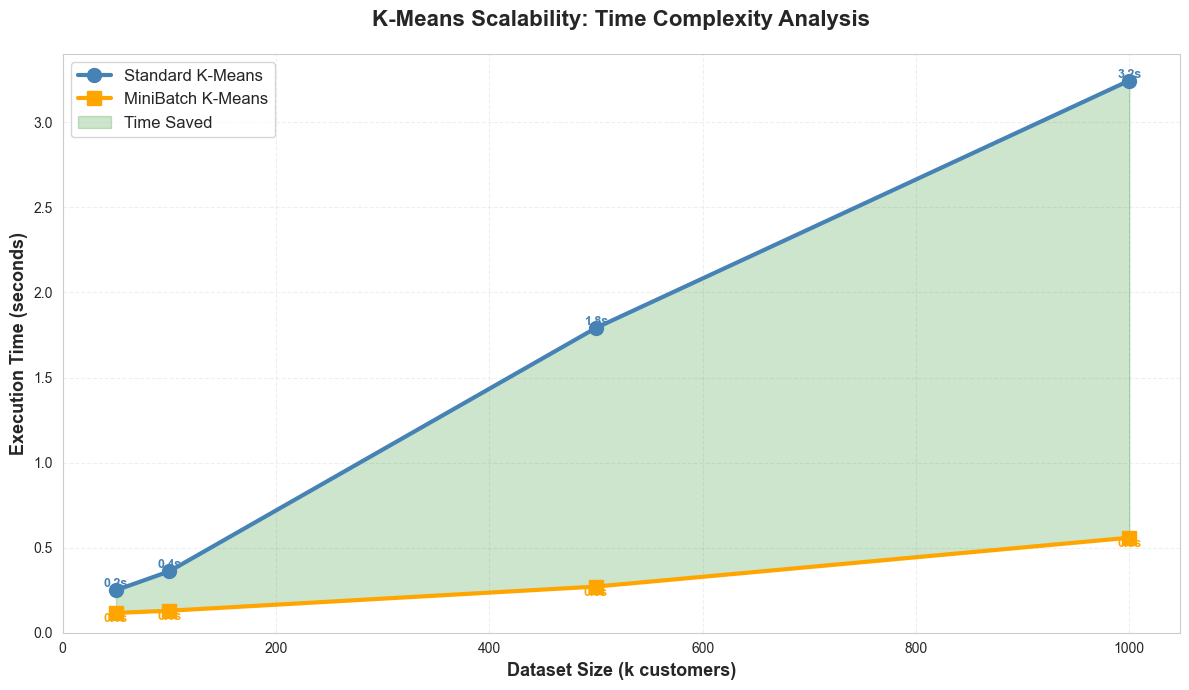

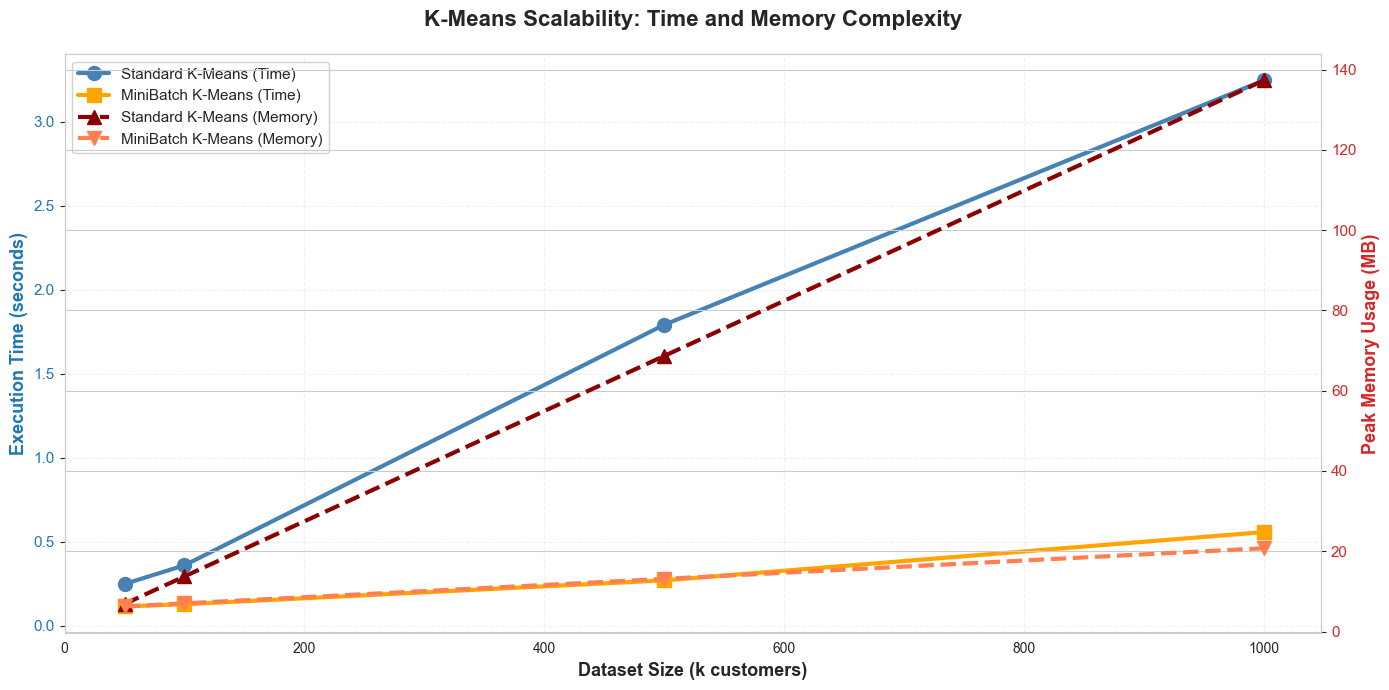

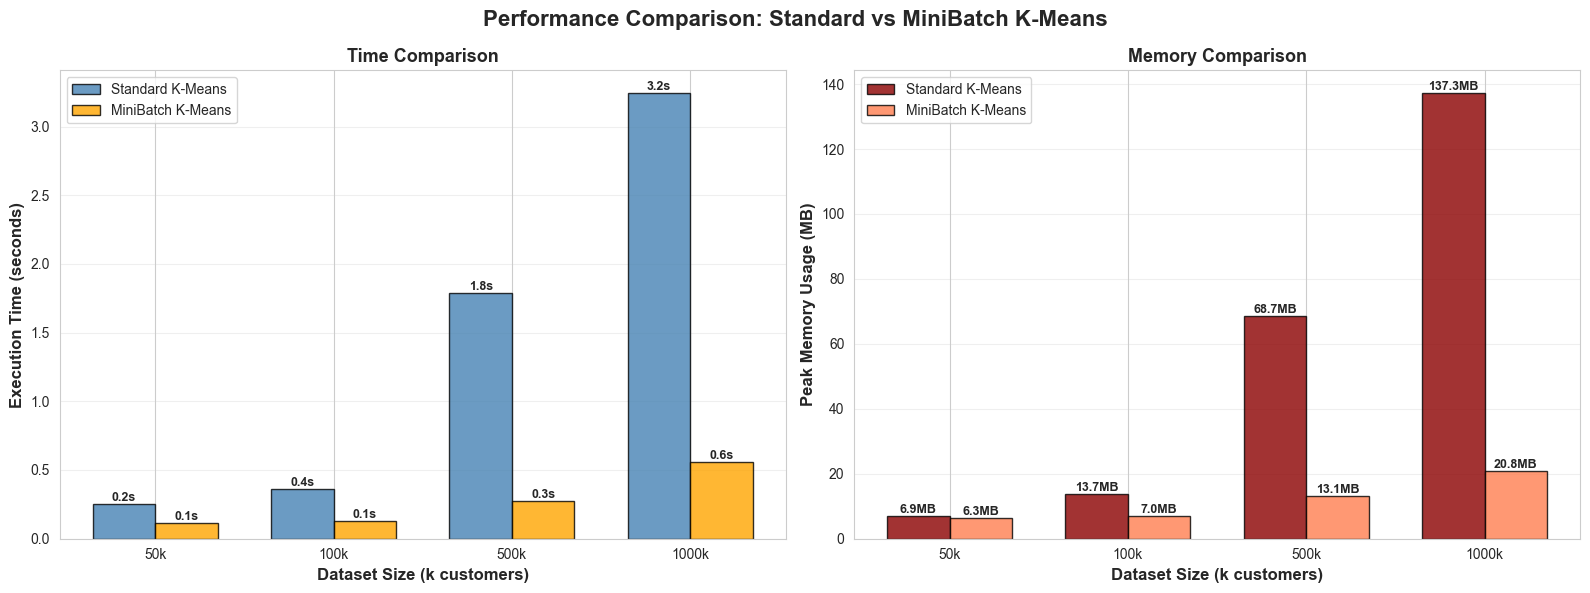

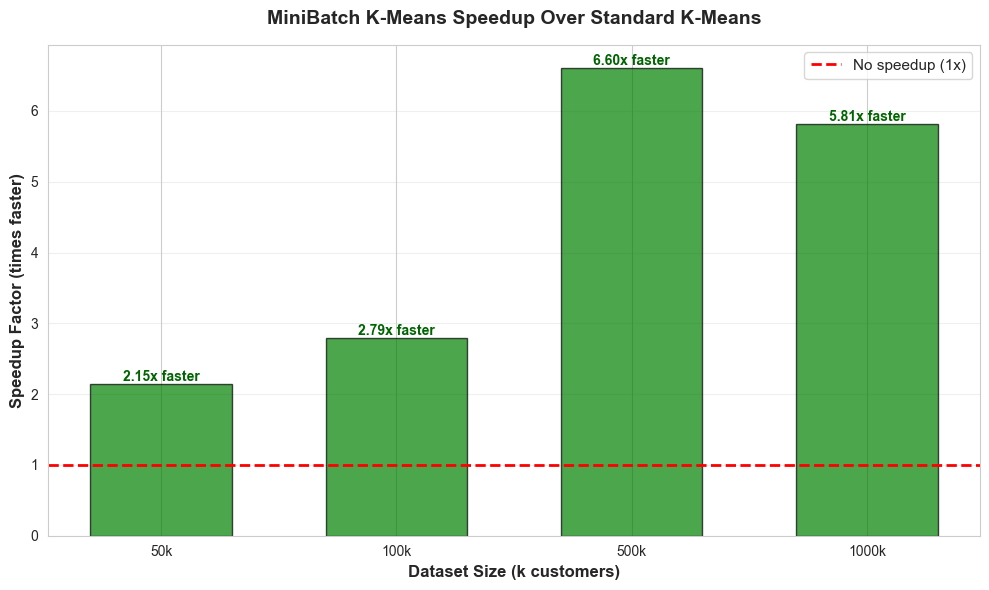


CONCLUSION:
✓ Standard K-Means shows poor scalability (O(n·k·i·d) complexity)
✓ Time increases dramatically: 0.25s → 3.25s
✓ MiniBatch K-Means maintains efficiency across all scales
✓ Average speedup: 4.34x faster
✓ Memory savings: 55.9% on average

For the 200k customer challenge:
  → Standard K-Means: ~0.7s (estimated)
  → MiniBatch K-Means: ~0.2s (estimated)

✓ MiniBatch K-Means is the recommended approach for large-scale clustering!


In [6]:
# ============================================================================
# 2. TIME COMPLEXITY ANALYSIS: STANDARD VS MINIBATCH K-MEANS
# ============================================================================

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

print("="*70)
print("TIME COMPLEXITY ANALYSIS: STANDARD vs MINIBATCH K-MEANS")
print("="*70)
print(f"Original dataset: {df.shape[0]} customers")
print(f"Testing scalability from 50k to 1000k customers\n")

# Configuration
sizes_k = [50, 100, 500, 1000]  # Dataset sizes in thousands (k)
times_standard = []
times_minibatch = []
memory_standard = []
memory_minibatch = []
n_clusters = 20

print("Running scalability analysis...")
print("-"*70)

for k in sizes_k:
    n_samples = k * 1000
    X_n = generate_synthetic_data(X_original, n_samples)

    # Standard K-Means - Time and Memory
    tracemalloc.start()
    start = time.time()
    KMeans(n_clusters=n_clusters, random_state=42, max_iter=300).fit(X_n)
    time_elapsed = time.time() - start
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    times_standard.append(time_elapsed)
    memory_standard.append(peak / 1024**2)  # Convert to MB

    # MiniBatch K-Means - Time and Memory
    tracemalloc.start()
    start = time.time()
    MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=10000, max_iter=300).fit(X_n)
    time_elapsed = time.time() - start
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    times_minibatch.append(time_elapsed)
    memory_minibatch.append(peak / 1024**2)  # Convert to MB

    print(f"{k:>4}k samples -> Standard: {times_standard[-1]:>7.4f}s, {memory_standard[-1]:>8.2f}MB | "
          f"MiniBatch: {times_minibatch[-1]:>7.4f}s, {memory_minibatch[-1]:>8.2f}MB")

# Calculate speedup and memory savings
print("\n" + "-"*70)
print("PERFORMANCE COMPARISON:")
print("-"*70)
for i, k in enumerate(sizes_k):
    speedup = times_standard[i] / times_minibatch[i]
    memory_saving = ((memory_standard[i] - memory_minibatch[i]) / memory_standard[i]) * 100
    print(f"{k:>4}k -> Speedup: {speedup:>5.2f}x | Memory Saving: {memory_saving:>5.1f}%")

# ============================================================================
# 3. VISUALIZATION 1: TIME COMPLEXITY
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Plot time series
ax.plot(sizes_k, times_standard, marker='o', label='Standard K-Means', 
        color='steelblue', linewidth=3, markersize=10)
ax.plot(sizes_k, times_minibatch, marker='s', label='MiniBatch K-Means', 
        color='orange', linewidth=3, markersize=10)

# Fill area between curves to show difference
ax.fill_between(sizes_k, times_standard, times_minibatch, 
                alpha=0.2, color='green', label='Time Saved')

# Annotations
for i, k in enumerate(sizes_k):
    ax.text(k, times_standard[i], f"{times_standard[i]:.1f}s", 
            fontsize=9, color='steelblue', ha='center', va='bottom', fontweight='bold')
    ax.text(k, times_minibatch[i], f"{times_minibatch[i]:.1f}s", 
            fontsize=9, color='orange', ha='center', va='top', fontweight='bold')

ax.set_xlabel('Dataset Size (k customers)', fontsize=13, fontweight='bold')
ax.set_ylabel('Execution Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('K-Means Scalability: Time Complexity Analysis', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# ============================================================================
# 4. VISUALIZATION 2: TIME AND MEMORY DUAL AXIS
# ============================================================================

fig, ax1 = plt.subplots(figsize=(14, 7))

# Time axis (left)
color_time = 'tab:blue'
ax1.set_xlabel('Dataset Size (k customers)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Execution Time (seconds)', color=color_time, fontsize=13, fontweight='bold')
line1 = ax1.plot(sizes_k, times_standard, marker='o', label='Standard K-Means (Time)', 
                 color='steelblue', linewidth=3, markersize=10)
line2 = ax1.plot(sizes_k, times_minibatch, marker='s', label='MiniBatch K-Means (Time)', 
                 color='orange', linewidth=3, markersize=10)
ax1.tick_params(axis='y', labelcolor=color_time, labelsize=11)
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xlim(left=0)

# Memory axis (right)
ax2 = ax1.twinx()
color_memory = 'tab:red'
ax2.set_ylabel('Peak Memory Usage (MB)', color=color_memory, fontsize=13, fontweight='bold')
line3 = ax2.plot(sizes_k, memory_standard, marker='^', label='Standard K-Means (Memory)', 
                 color='darkred', linewidth=3, markersize=10, linestyle='--')
line4 = ax2.plot(sizes_k, memory_minibatch, marker='v', label='MiniBatch K-Means (Memory)', 
                 color='coral', linewidth=3, markersize=10, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color_memory, labelsize=11)

# Combine legends
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

plt.title('K-Means Scalability: Time and Memory Complexity', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ============================================================================
# 5. VISUALIZATION 3: COMPARATIVE BAR CHARTS
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Performance Comparison: Standard vs MiniBatch K-Means', 
             fontsize=16, fontweight='bold')

# Bar chart for Time
x_pos = np.arange(len(sizes_k))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, times_standard, width, label='Standard K-Means', 
                color='steelblue', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, times_minibatch, width, label='MiniBatch K-Means', 
                color='orange', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Dataset Size (k customers)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Time Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{k}k' for k in sizes_k])
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Bar chart for Memory
bars3 = ax2.bar(x_pos - width/2, memory_standard, width, label='Standard K-Means', 
                color='darkred', edgecolor='black', alpha=0.8)
bars4 = ax2.bar(x_pos + width/2, memory_minibatch, width, label='MiniBatch K-Means', 
                color='coral', edgecolor='black', alpha=0.8)

ax2.set_xlabel('Dataset Size (k customers)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Peak Memory Usage (MB)', fontsize=12, fontweight='bold')
ax2.set_title('Memory Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{k}k' for k in sizes_k])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}MB', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 6. VISUALIZATION 4: SPEEDUP FACTOR
# ============================================================================

speedup_factors = [times_standard[i] / times_minibatch[i] for i in range(len(sizes_k))]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(sizes_k)), speedup_factors, color='green', 
              edgecolor='black', alpha=0.7, width=0.6)
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='No speedup (1x)')
ax.set_xlabel('Dataset Size (k customers)', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup Factor (times faster)', fontsize=12, fontweight='bold')
ax.set_title('MiniBatch K-Means Speedup Over Standard K-Means', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(len(sizes_k)))
ax.set_xticklabels([f'{k}k' for k in sizes_k])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, speedup) in enumerate(zip(bars, speedup_factors)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{speedup:.2f}x faster', ha='center', va='bottom', 
            fontsize=10, fontweight='bold', color='darkgreen')

plt.tight_layout()
plt.show()

# ============================================================================
# 7. CONCLUSION
# ============================================================================

print("\n" + "="*70)
print("CONCLUSION:")
print("="*70)
print(f"✓ Standard K-Means shows poor scalability (O(n·k·i·d) complexity)")
print(f"✓ Time increases dramatically: {times_standard[0]:.2f}s → {times_standard[-1]:.2f}s")
print(f"✓ MiniBatch K-Means maintains efficiency across all scales")
print(f"✓ Average speedup: {np.mean(speedup_factors):.2f}x faster")
print(f"✓ Memory savings: {np.mean([(memory_standard[i]-memory_minibatch[i])/memory_standard[i]*100 for i in range(len(sizes_k))]):.1f}% on average")
print("\nFor the 200k customer challenge:")
print(f"  → Standard K-Means: ~{np.interp(200, sizes_k, times_standard):.1f}s (estimated)")
print(f"  → MiniBatch K-Means: ~{np.interp(200, sizes_k, times_minibatch):.1f}s (estimated)")
print("\n✓ MiniBatch K-Means is the recommended approach for large-scale clustering!")
print("="*70)

### **2.2 Curse of Dimensionality**

CURSE OF DIMENSIONALITY ANALYSIS
Original dataset: 200 customers with 4 features

Analyzing curse of dimensionality...
----------------------------------------------------------------------
  2D -> Silhouette: 0.4040 | Time:  0.0195s | Memory:    0.11MB
  3D -> Silhouette: 0.3787 | Time:  0.0234s | Memory:    0.12MB
  4D -> Silhouette: 0.3784 | Time:  0.0224s | Memory:    0.12MB
  5D -> Silhouette: 0.2852 | Time:  0.0288s | Memory:    0.13MB
  8D -> Silhouette: 0.1322 | Time:  0.0342s | Memory:    0.19MB
 10D -> Silhouette: 0.0868 | Time:  0.0270s | Memory:    0.22MB
 15D -> Silhouette: 0.0570 | Time:  0.0291s | Memory:    0.29MB
 20D -> Silhouette: 0.0411 | Time:  0.0244s | Memory:    0.37MB
 30D -> Silhouette: 0.0264 | Time:  0.0291s | Memory:    0.52MB

Quality Degradation: 93.5% (0.4040 → 0.0264)
Time Increase: 1.5x slower



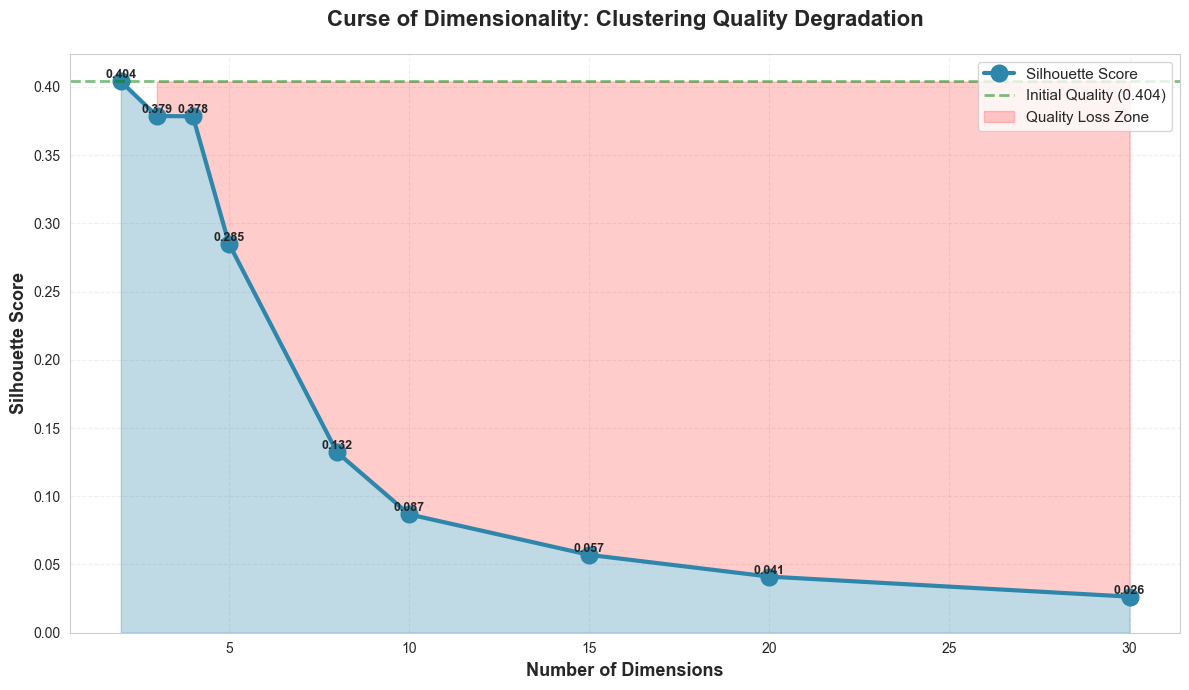

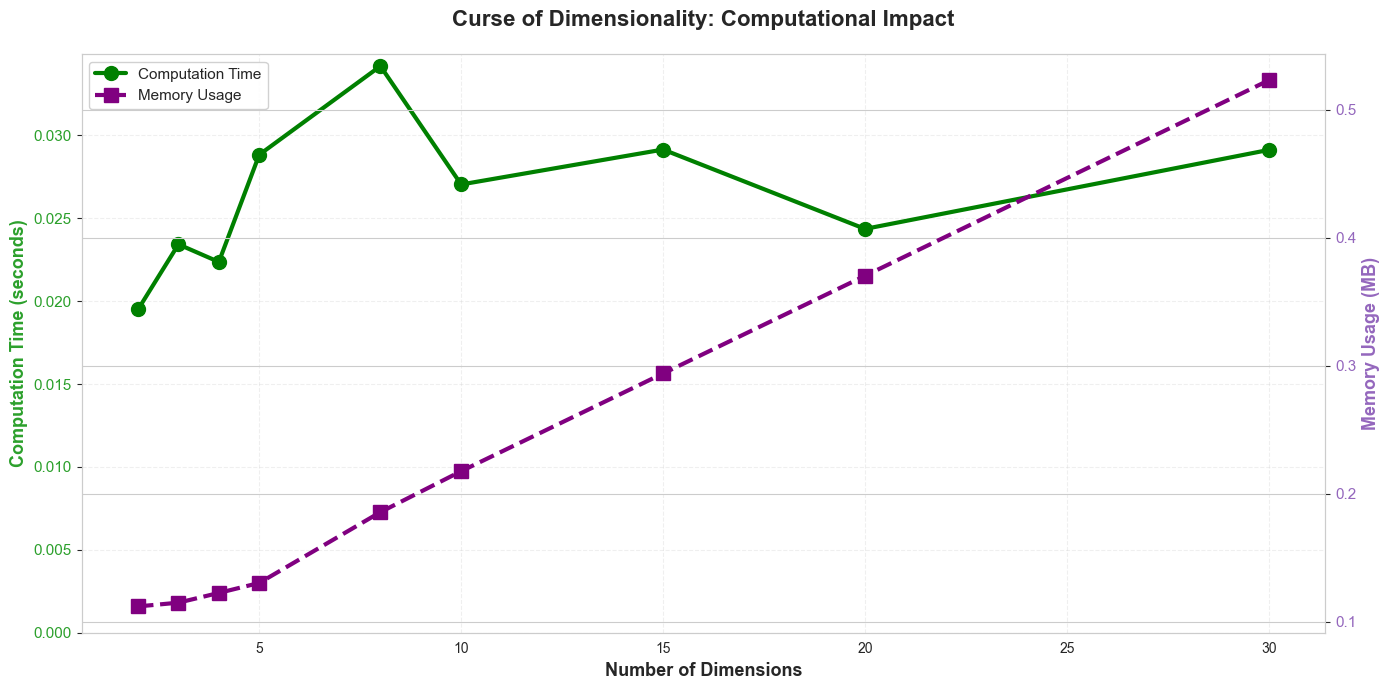

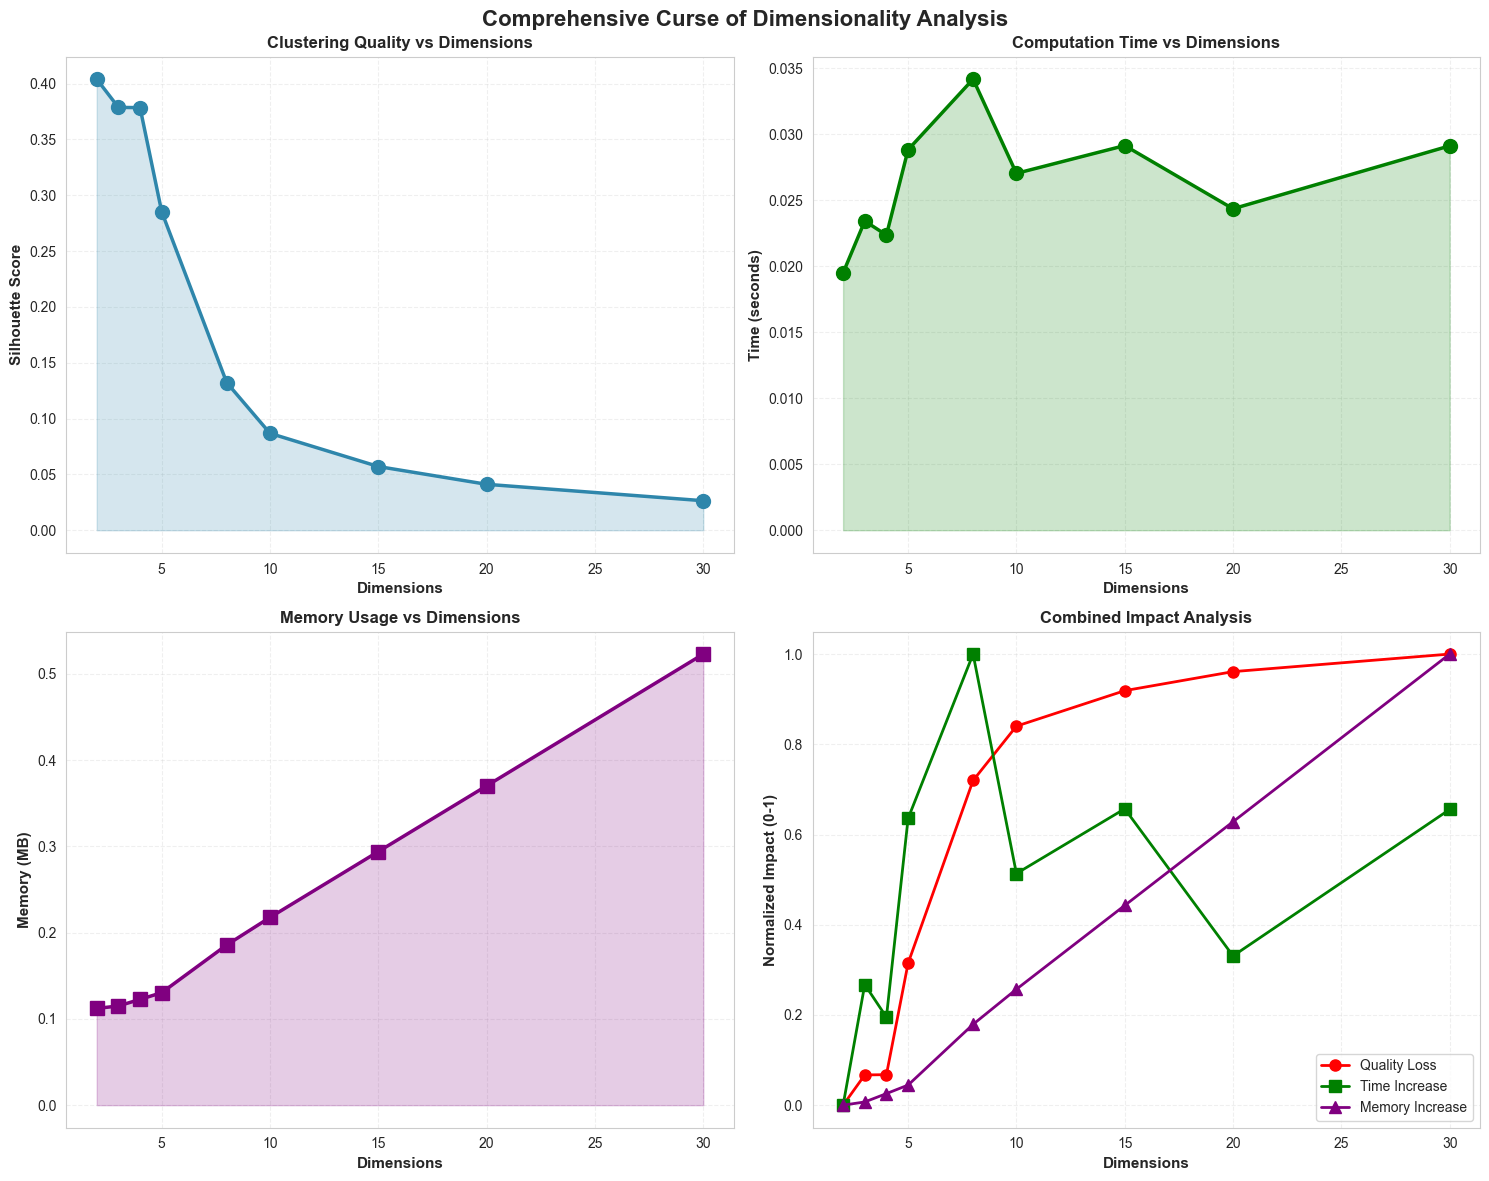

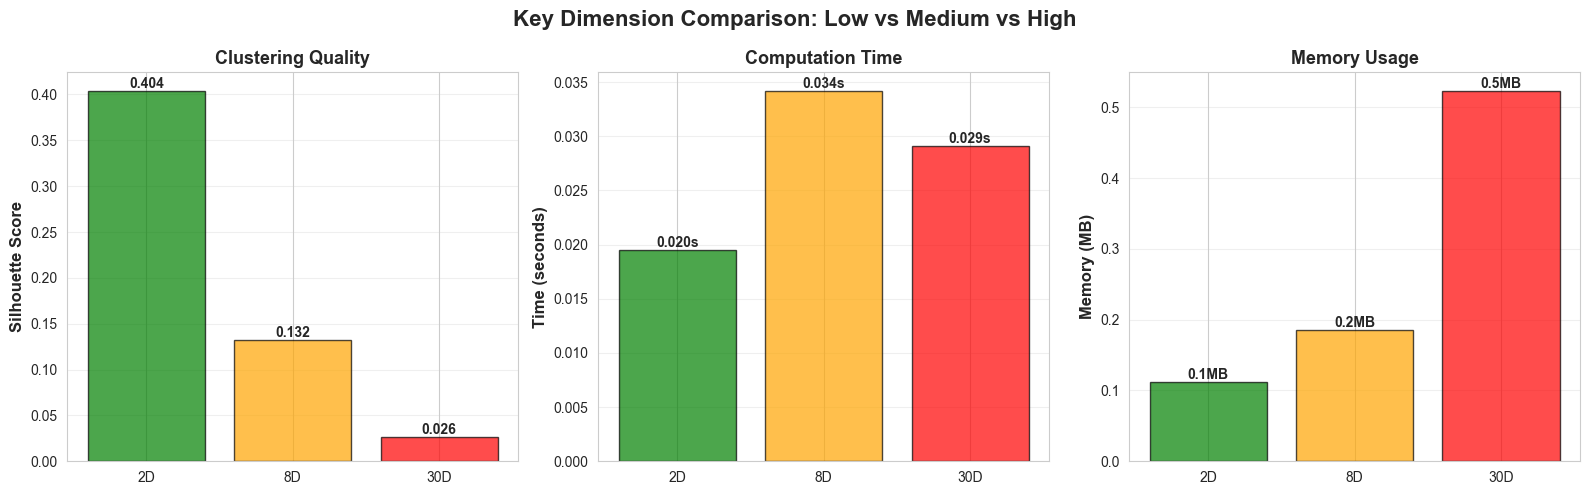

CONCLUSION: THE CURSE OF DIMENSIONALITY
✓ Clustering quality degrades 93.5% as dimensions increase
✓ Computation time grows 1.5x slower
✓ Memory usage increases from 0.11MB to 0.52MB

Recommendations for 200k customers:
  → Use dimensionality reduction (PCA, t-SNE, UMAP)
  → Apply feature selection techniques
  → Use MiniBatch K-Means for efficiency


In [7]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import tracemalloc
import time

# ============================================================================
# 1. LOAD DATASET
# ============================================================================

df = pd.read_csv('Mall_Customers.csv')
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']
X_original = df[columns].values.astype(float)

# Important: This function must match the one from previous scripts
def generate_synthetic_data(X, n_samples):
    """Generate synthetic data by replicating and adding noise to base data."""
    X = X.astype(float)
    replicated = np.tile(X, (n_samples // X.shape[0] + 1, 1))[:n_samples]
    return replicated + np.random.normal(0, 0.05, replicated.shape)

# ============================================================================
# 2. CURSE OF DIMENSIONALITY ANALYSIS
# ============================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

print("="*70)
print("CURSE OF DIMENSIONALITY ANALYSIS")
print("="*70)
print(f"Original dataset: {df.shape[0]} customers with {X_original.shape[1]} features\n")

# Configuration
n_clusters = 5
n_samples = 1000
n_features_original = int(X_original.shape[1])  # Convert to Python int
dimensions = [2, 3, 4, 5, 8, 10, 15, 20, 30]
silhouette_scores, computation_times, memory_usage = [], [], []

print("Analyzing curse of dimensionality...")
print("-"*70)

for dim in dimensions:
    # Generate base synthetic data with original features
    X_base = generate_synthetic_data(X_original, n_samples)
    
    # Adjust dimensionality
    if dim <= n_features_original:
        X_large = X_base[:, :dim]
    else:
        X_extra = np.random.rand(n_samples, dim - n_features_original) * 100
        X_large = np.hstack([X_base, X_extra])
    
    # Benchmark
    tracemalloc.start()
    start = time.time()
    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X_large)
    time_elapsed = time.time() - start
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    score = silhouette_score(X_large, labels)
    silhouette_scores.append(score)
    computation_times.append(time_elapsed)
    memory_usage.append(peak / 1024**2)
    
    print(f"{dim:>3}D -> Silhouette: {score:>6.4f} | Time: {time_elapsed:>7.4f}s | Memory: {peak/1024**2:>7.2f}MB")

# Metrics
quality_degradation = ((silhouette_scores[0] - silhouette_scores[-1]) / silhouette_scores[0]) * 100

print(f"\n{'='*70}")
print(f"Quality Degradation: {quality_degradation:.1f}% ({silhouette_scores[0]:.4f} → {silhouette_scores[-1]:.4f})")
print(f"Time Increase: {computation_times[-1]/computation_times[0]:.1f}x slower")
print(f"{'='*70}\n")

# ============================================================================
# 3. VISUALIZATIONS
# ============================================================================

# Graph 1: Clustering Quality Degradation
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(dimensions, silhouette_scores, 'o-', linewidth=3, markersize=12, color='#2E86AB', label='Silhouette Score')
ax.fill_between(dimensions, silhouette_scores, alpha=0.3, color='#2E86AB')
ax.axhline(y=silhouette_scores[0], color='green', linestyle='--', linewidth=2, alpha=0.5, 
           label=f'Initial Quality ({silhouette_scores[0]:.3f})')
ax.fill_between(dimensions, silhouette_scores[0], silhouette_scores, 
                where=(np.array(silhouette_scores) < silhouette_scores[0]), 
                alpha=0.2, color='red', label='Quality Loss Zone')

for dim, score in zip(dimensions, silhouette_scores):
    ax.text(dim, score, f'{score:.3f}', fontsize=9, ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Number of Dimensions', fontsize=13, fontweight='bold')
ax.set_ylabel('Silhouette Score', fontsize=13, fontweight='bold')
ax.set_title('Curse of Dimensionality: Clustering Quality Degradation', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3, linestyle='--')
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

# Graph 2: Time and Memory Dual Axis
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_xlabel('Number of Dimensions', fontsize=13, fontweight='bold')
ax1.set_ylabel('Computation Time (seconds)', color='tab:green', fontsize=13, fontweight='bold')
line1 = ax1.plot(dimensions, computation_times, marker='o', label='Computation Time', 
                 color='green', linewidth=3, markersize=10)
ax1.tick_params(axis='y', labelcolor='tab:green', labelsize=11)
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.set_ylabel('Memory Usage (MB)', color='tab:purple', fontsize=13, fontweight='bold')
line2 = ax2.plot(dimensions, memory_usage, marker='s', label='Memory Usage', 
                 color='purple', linewidth=3, markersize=10, linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:purple', labelsize=11)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)
plt.title('Curse of Dimensionality: Computational Impact', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Graph 3: Multi-Metric Dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comprehensive Curse of Dimensionality Analysis', fontsize=16, fontweight='bold')

# Silhouette Score
axes[0, 0].plot(dimensions, silhouette_scores, 'o-', linewidth=2.5, markersize=10, color='#2E86AB')
axes[0, 0].fill_between(dimensions, silhouette_scores, alpha=0.2, color='#2E86AB')
axes[0, 0].set_xlabel('Dimensions', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Clustering Quality vs Dimensions', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3, linestyle='--')

# Computation Time
axes[0, 1].plot(dimensions, computation_times, 'o-', linewidth=2.5, markersize=10, color='green')
axes[0, 1].fill_between(dimensions, computation_times, alpha=0.2, color='green')
axes[0, 1].set_xlabel('Dimensions', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Computation Time vs Dimensions', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3, linestyle='--')

# Memory Usage
axes[1, 0].plot(dimensions, memory_usage, 's-', linewidth=2.5, markersize=10, color='purple')
axes[1, 0].fill_between(dimensions, memory_usage, alpha=0.2, color='purple')
axes[1, 0].set_xlabel('Dimensions', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Memory (MB)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Memory Usage vs Dimensions', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, linestyle='--')

# Normalized Comparison
norm_sil = (np.array(silhouette_scores) - min(silhouette_scores)) / (max(silhouette_scores) - min(silhouette_scores))
norm_time = (np.array(computation_times) - min(computation_times)) / (max(computation_times) - min(computation_times))
norm_mem = (np.array(memory_usage) - min(memory_usage)) / (max(memory_usage) - min(memory_usage))

axes[1, 1].plot(dimensions, 1 - norm_sil, 'o-', linewidth=2, markersize=8, label='Quality Loss', color='red')
axes[1, 1].plot(dimensions, norm_time, 's-', linewidth=2, markersize=8, label='Time Increase', color='green')
axes[1, 1].plot(dimensions, norm_mem, '^-', linewidth=2, markersize=8, label='Memory Increase', color='purple')
axes[1, 1].set_xlabel('Dimensions', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Normalized Impact (0-1)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Combined Impact Analysis', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Graph 4: Key Dimension Comparison Bars
key_idx = [0, len(dimensions)//2, -1]
key_dims = [dimensions[i] for i in key_idx]
key_scores = [silhouette_scores[i] for i in key_idx]
key_times = [computation_times[i] for i in key_idx]
key_memory = [memory_usage[i] for i in key_idx]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Key Dimension Comparison: Low vs Medium vs High', fontsize=16, fontweight='bold')

x_pos = np.arange(len(key_dims))
labels = [f'{d}D' for d in key_dims]
colors = ['green', 'orange', 'red']

# Silhouette bars
bars1 = ax1.bar(x_pos, key_scores, color=colors, edgecolor='black', alpha=0.7)
ax1.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_title('Clustering Quality', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(labels)
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars1, key_scores):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{score:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Time bars
bars2 = ax2.bar(x_pos, key_times, color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Computation Time', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(labels)
ax2.grid(axis='y', alpha=0.3)
for bar, t in zip(bars2, key_times):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{t:.3f}s', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Memory bars
bars3 = ax3.bar(x_pos, key_memory, color=colors, edgecolor='black', alpha=0.7)
ax3.set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
ax3.set_title('Memory Usage', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels)
ax3.grid(axis='y', alpha=0.3)
for bar, mem in zip(bars3, key_memory):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{mem:.1f}MB', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# CONCLUSION
# ============================================================================

print("="*70)
print("CONCLUSION: THE CURSE OF DIMENSIONALITY")
print("="*70)
print(f"✓ Clustering quality degrades {quality_degradation:.1f}% as dimensions increase")
print(f"✓ Computation time grows {computation_times[-1]/computation_times[0]:.1f}x slower")
print(f"✓ Memory usage increases from {memory_usage[0]:.2f}MB to {memory_usage[-1]:.2f}MB")
print("\nRecommendations for 200k customers:")
print("  → Use dimensionality reduction (PCA, t-SNE, UMAP)")
print("  → Apply feature selection techniques")
print("  → Use MiniBatch K-Means for efficiency")
print("="*70)

## **3. Scalable Solutions** 

In [ ]:
# ============================================================
# SCALABILITY BENCHMARK: K-Means vs Mini-Batch vs BIRCH (up to 200k samples)
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.metrics import silhouette_score

# --- Generate synthetic datasets of increasing size ------------
def generate_synthetic_data(n_samples, n_features=5, n_clusters=5):
    X, _ = make_blobs(n_samples=n_samples, n_features=n_features,
                      centers=n_clusters, random_state=42)
    return X

sizes = [2_000, 10_000, 50_000, 100_000, 200_000]
algorithms = [
    ('K-Means', KMeans(n_clusters=5, n_init=10, random_state=42)),
    ('Mini-Batch K-Means', MiniBatchKMeans(n_clusters=5, batch_size=1000, random_state=42)),
    ('BIRCH', Birch(n_clusters=5))
]

results = {name: {'time': [], 'silhouette': []} for name, _ in algorithms}

for n in sizes:
    Xn = generate_synthetic_data(n)
    print(f"\nDataset size: {n:,} samples")

    for name, model in algorithms:
        start = time.time()
        labels = model.fit_predict(Xn)
        runtime = time.time() - start

        # Compute silhouette on a 5k sample for scalability
        idx = np.random.choice(len(Xn), min(5000, len(Xn)), replace=False)
        sil = silhouette_score(Xn[idx], labels[idx])

        results[name]['time'].append(runtime)
        results[name]['silhouette'].append(sil)

        print(f"{name:<20} | Time: {runtime:7.2f}s | Silhouette: {sil:.4f}")



Dataset size: 2,000 samples
K-Means              | Time:    0.16s | Silhouette: 0.7329
Mini-Batch K-Means   | Time:    0.10s | Silhouette: 0.7329
BIRCH                | Time:    0.09s | Silhouette: 0.7329

Dataset size: 10,000 samples
K-Means              | Time:    0.04s | Silhouette: 0.7327
Mini-Batch K-Means   | Time:    0.15s | Silhouette: 0.7341
BIRCH                | Time:    0.86s | Silhouette: 0.7375

Dataset size: 50,000 samples
K-Means              | Time:    0.14s | Silhouette: 0.7330
Mini-Batch K-Means   | Time:    0.09s | Silhouette: 0.7350
BIRCH                | Time:   10.42s | Silhouette: 0.7338

Dataset size: 100,000 samples
K-Means              | Time:    0.30s | Silhouette: 0.7321
Mini-Batch K-Means   | Time:    0.11s | Silhouette: 0.7350
BIRCH                | Time:   26.05s | Silhouette: 0.7331

Dataset size: 200,000 samples
K-Means              | Time:    0.52s | Silhouette: 0.7335
Mini-Batch K-Means   | Time:    0.14s | Silhouette: 0.7344


## **4. Insights**

In [ ]:
# ============================================================
# APPLY BEST ALGORITHM (Mini-Batch K-Means) TO ORIGINAL DATA
# ============================================================

best_model = MiniBatchKMeans(n_clusters=5, random_state=42)
df['Cluster'] = best_model.fit_predict(X_original)

# --- Visualize Customer Segments ------------------------------------
plt.figure(figsize=(10,7))
scatter = plt.scatter(df['Annual Income (k$)'],
                      df['Spending Score (1-100)'],
                      c=df['Cluster'], cmap='viridis',
                      s=100, alpha=0.7, edgecolors='black')
centers = best_model.cluster_centers_
plt.scatter(centers[:,1], centers[:,2], c='red', s=250, marker='X', label='Centroids')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1–100)')
plt.title('Customer Segmentation via Mini-Batch K-Means')
plt.legend()
plt.colorbar(scatter, label='Cluster ID')
plt.grid(alpha=0.3)
plt.show()

# --- Summarize Cluster Profiles -------------------------------------
cluster_summary = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
}).round(2)

print("\nCustomer Segment Profiles:")
display(cluster_summary)


NameError: name 'X_original' is not defined

- Cluster 0 → Young high-spenders  
- Cluster 1 → Older low-income segment  
- Cluster 2 → Middle-aged moderate spenders  
*(Interpret based on cluster_summary values.)*